In [103]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn as sk
import os
import tarfile
from six.moves import urllib
from scipy import stats
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor

Fetch the data:

In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("../datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)

    tgz_path = os.path.join(housing_path, "housing.tgz")

    urllib.request.urlretrieve(housing_url, tgz_path)

    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

# fetch_housing_data()

Loading housing file:

In [3]:
def load_housing_data():
    HOUSING_PATH = '../datasets/housing/housing.csv'
    return pd.read_csv(HOUSING_PATH)

housing_data = load_housing_data()
housing_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
housing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
housing_data['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [6]:
housing_data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


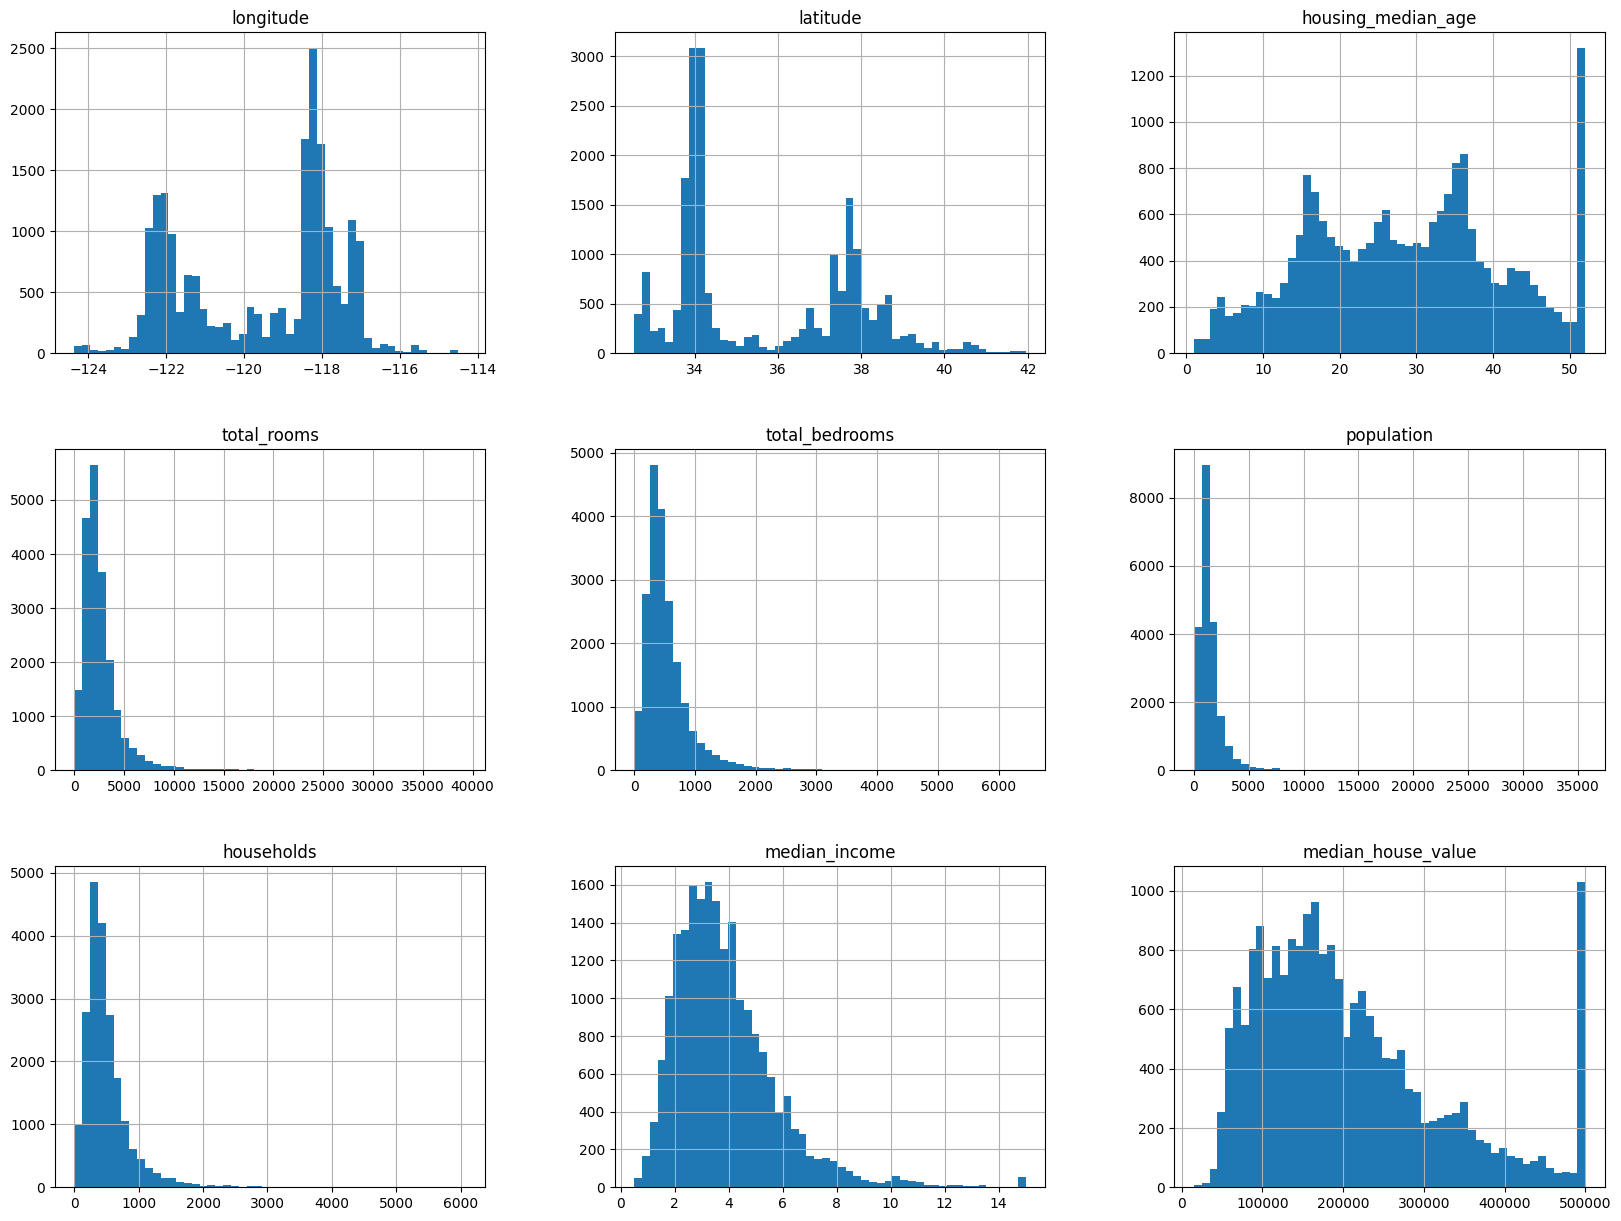

In [7]:
housing_data.hist(bins=50, figsize=(20,15))
plt.show()

In [8]:
train_set, test_set = train_test_split(housing_data, test_size=0.2, random_state=42)

<AxesSubplot: >

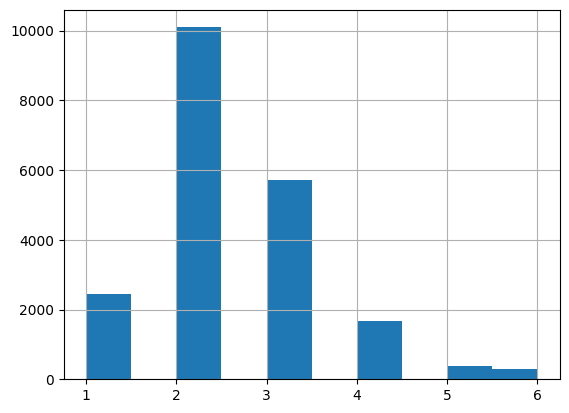

In [9]:
housing_data['income_cat'] = pd.cut(housing_data['median_income'],
                                    bins=[0,2,4,6,8,10,np.inf],
                                    labels=[1,2,3,4,5,6])
housing_data['income_cat'].hist()

In [10]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for i_train, i_test in split.split(housing_data, housing_data["income_cat"]):
    strat_train = housing_data.loc[i_train]
    strat_test = housing_data.loc[i_test]

In [11]:
strat_test["income_cat"].value_counts()/len(strat_test)

2    0.489099
3    0.277374
1    0.119186
4    0.080911
5    0.018411
6    0.015019
Name: income_cat, dtype: float64

In [12]:
housing_data['income_cat'].values

[5, 5, 4, 3, 2, ..., 1, 2, 1, 1, 2]
Length: 20640
Categories (6, int64): [1 < 2 < 3 < 4 < 5 < 6]

In [13]:
train_ic, test_ic  = train_test_split(housing_data['income_cat'], test_size=0.2, random_state=42)

In [14]:
print(housing_data['income_cat'].value_counts()/len(housing_data['income_cat']))
print(test_ic.value_counts()/len(test_ic))
print(strat_test['income_cat'].value_counts()/len(strat_test))

2    0.489147
3    0.277374
1    0.119041
4    0.081008
5    0.018508
6    0.014922
Name: income_cat, dtype: float64
2    0.500484
3    0.269138
1    0.120882
4    0.076793
5    0.017442
6    0.015262
Name: income_cat, dtype: float64
2    0.489099
3    0.277374
1    0.119186
4    0.080911
5    0.018411
6    0.015019
Name: income_cat, dtype: float64


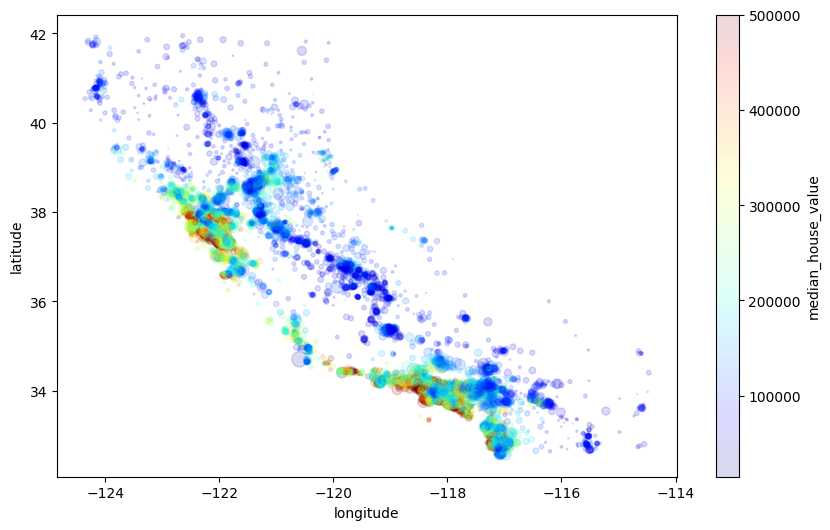

In [15]:
strat_train.plot(kind='scatter', x='longitude', y='latitude', alpha=0.15, figsize=(10,6), s=strat_train['population']/100, c='median_house_value', cmap='jet')
plt.show()

In [16]:
corr_matrix = strat_train.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687296
total_rooms           0.132946
housing_median_age    0.112063
households            0.063411
total_bedrooms        0.047024
population           -0.028196
longitude            -0.044798
latitude             -0.144342
Name: median_house_value, dtype: float64

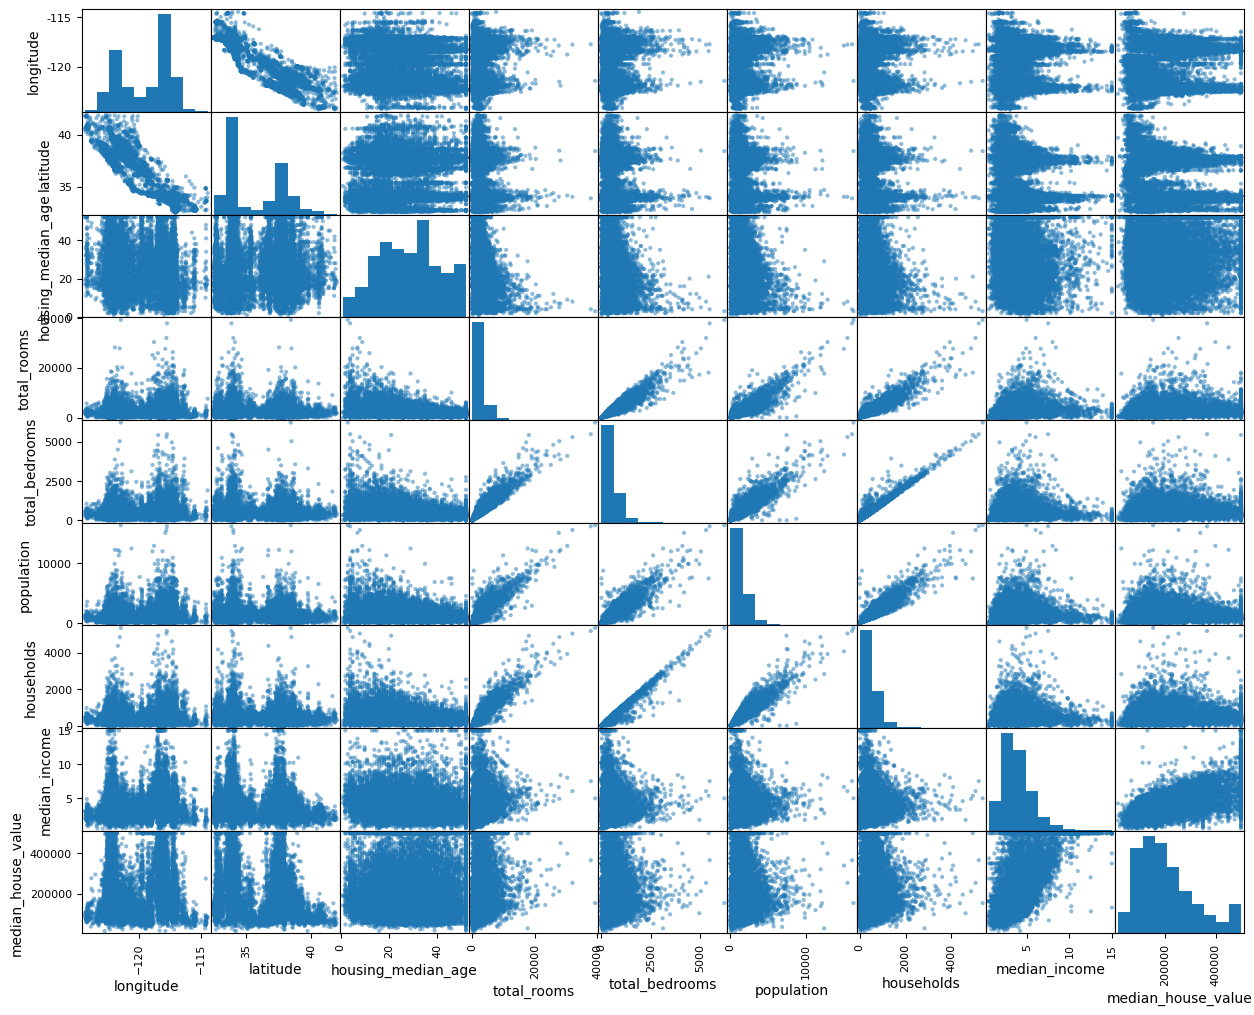

In [17]:
scatter_matrix(strat_train, figsize=(15,12))
plt.show()

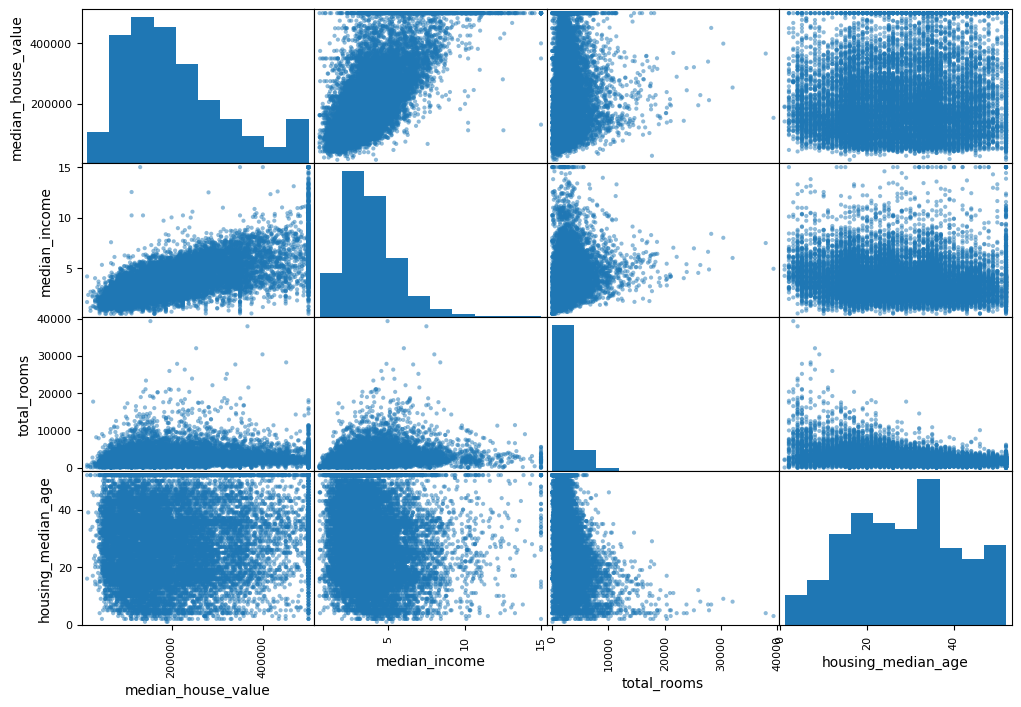

In [18]:
attributes = ['median_house_value','median_income','total_rooms','housing_median_age']
scatter_matrix(strat_train[attributes], figsize=(12,8))
plt.show()

In [19]:
housing = strat_train.copy()

In [20]:
housing['rooms_per_household'] = housing['total_rooms']/housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms']/housing['total_rooms']
housing['population_per_household'] = housing['population']/housing['households']

In [21]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687296
rooms_per_household         0.144120
total_rooms                 0.132946
housing_median_age          0.112063
households                  0.063411
total_bedrooms              0.047024
population_per_household   -0.022536
population                 -0.028196
longitude                  -0.044798
latitude                   -0.144342
bedrooms_per_room          -0.257775
Name: median_house_value, dtype: float64

In [22]:
housing = strat_train.drop('median_house_value',axis=1)
housing = housing.drop('income_cat',axis=1)
housing_labels = strat_train['median_house_value'].copy()

In [23]:
print(housing['total_bedrooms'].isna().value_counts())
print(housing['total_bedrooms'].isnull().value_counts())

False    16344
True       168
Name: total_bedrooms, dtype: int64
False    16344
True       168
Name: total_bedrooms, dtype: int64


In [24]:
housing_dropna = housing.dropna(subset=['total_bedrooms'])
# housing.drop('total_bedrooms',axis=1)
# median = housing['total_bedrooms'].median()
# housing['total_bedrooms'].fillna(median, inplace=True)

In [25]:
housing_dropna['total_bedrooms'].isna().value_counts()

False    16344
Name: total_bedrooms, dtype: int64

In [26]:
imputer = SimpleImputer(strategy='median')

In [27]:
housing_num = housing.drop('ocean_proximity', axis=1)

In [28]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [29]:
imputer.statistics_

array([-118.49  ,   34.26  ,   29.    , 2134.    ,  436.    , 1170.5   ,
        410.    ,    3.5417])

In [30]:
housing_num.median().values

array([-118.49  ,   34.26  ,   29.    , 2134.    ,  436.    , 1170.5   ,
        410.    ,    3.5417])

In [31]:
X = imputer.transform(housing_num)
X_pd = pd.DataFrame(X, columns=housing_num.columns)

In [32]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head(10)

,ocean_proximity
6802,<1H OCEAN
2867,INLAND
3239,INLAND
16447,INLAND
17312,<1H OCEAN
16475,INLAND
2433,INLAND
16145,NEAR BAY
3995,<1H OCEAN
12506,INLAND


In [33]:
ordinal_encoder = OrdinalEncoder()

In [34]:
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded

array([[0.],
       [1.],
       [1.],
       ...,
       [4.],
       [4.],
       [0.]])

In [35]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [36]:
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [37]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.]])

In [43]:
scale_mm = MinMaxScaler((0,1))
scale_mm.fit(X)
X_mm = scale_mm.transform(X)
X_mm

array([[0.62955466, 0.16471838, 0.80392157, ..., 0.11857441, 0.12805675,
        0.1187225 ],
       [0.548583  , 0.30074389, 0.64705882, ..., 0.09538707, 0.07840209,
        0.15105999],
       [0.48481781, 0.37725824, 0.66666667, ..., 0.04839897, 0.04928131,
        0.19205252],
       ...,
       [0.73279352, 0.01700319, 0.70588235, ..., 0.11759293, 0.08792234,
        0.09052289],
       [0.72773279, 0.02125399, 1.        , ..., 0.02367808, 0.04629457,
        0.14512214],
       [0.57591093, 0.17534538, 0.43137255, ..., 0.19739909, 0.19451185,
        0.49255183]])

In [44]:
scale_std = StandardScaler()
scale_std.fit(X)
X_std = scale_std.transform(X)
X_std

array([[ 0.7194324 , -0.72371939,  1.06748393, ...,  0.46440442,
         0.4859608 , -0.86957833],
       [ 0.32009337, -0.12403531,  0.43122164, ...,  0.1193909 ,
        -0.2100749 , -0.62249441],
       [ 0.00561389,  0.21328698,  0.51075443, ..., -0.57976347,
        -0.61827628, -0.30927905],
       ...,
       [ 1.22858966, -1.37493881,  0.66982   , ...,  0.44980067,
        -0.07662444, -1.08504562],
       [ 1.20363097, -1.35619869,  1.86281179, ..., -0.94759534,
        -0.66014309, -0.66786426],
       [ 0.45487029, -0.67686907, -0.443639  , ...,  1.63726783,
         1.41749728,  1.9867729 ]])

In [49]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())
])

housing_num_pip = num_pipeline.fit_transform(housing_num)

In [50]:
housing_num_pip

array([[ 0.7194324 , -0.72371939,  1.06748393, ...,  0.46440442,
         0.4859608 , -0.86957833],
       [ 0.32009337, -0.12403531,  0.43122164, ...,  0.1193909 ,
        -0.2100749 , -0.62249441],
       [ 0.00561389,  0.21328698,  0.51075443, ..., -0.57976347,
        -0.61827628, -0.30927905],
       ...,
       [ 1.22858966, -1.37493881,  0.66982   , ...,  0.44980067,
        -0.07662444, -1.08504562],
       [ 1.20363097, -1.35619869,  1.86281179, ..., -0.94759534,
        -0.66014309, -0.66786426],
       [ 0.45487029, -0.67686907, -0.443639  , ...,  1.63726783,
         1.41749728,  1.9867729 ]])

In [51]:
num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']
full_pipeline = ColumnTransformer([
    ('num',num_pipeline,num_attribs),
    ('cat',OneHotEncoder(), cat_attribs),
])

housing_prepared = full_pipeline.fit_transform(housing)

In [54]:
housing_prepared

array([[ 0.7194324 , -0.72371939,  1.06748393, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.32009337, -0.12403531,  0.43122164, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.00561389,  0.21328698,  0.51075443, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.22858966, -1.37493881,  0.66982   , ...,  0.        ,
         0.        ,  1.        ],
       [ 1.20363097, -1.35619869,  1.86281179, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.45487029, -0.67686907, -0.443639  , ...,  0.        ,
         0.        ,  0.        ]])

In [56]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [62]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print('Predictions:', lin_reg.predict(some_data_prepared))
print('Labels:', list(some_labels))

Predictions: [180551.02334672 111007.79319569 146431.74649189 162159.57380716
 204549.41026319]
Labels: [219000.0, 62800.0, 64700.0, 99500.0, 62100.0]


In [65]:
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68462.48166348424

In [67]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [68]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [70]:
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, 
                         scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [71]:
print('Scores:', tree_rmse_scores)
print('Mean:', tree_rmse_scores.mean())
print('STD:',tree_rmse_scores.std())

Scores: [70709.45224117 66104.90503382 69690.6986689  65053.86777567
 68599.11862842 66735.69722956 64978.56355307 69747.05371157
 70202.65141072 72977.2376594 ]
Mean: 68479.92459123027
STD: 2528.4510035409903


In [76]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring='neg_mean_squared_error', cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

In [77]:
print('Scores:', lin_rmse_scores)
print('Mean:', lin_rmse_scores.mean())
print('STD:',lin_rmse_scores.std())

Scores: [71582.77889486 67066.69374535 68558.95615134 66467.01747387
 66931.91861953 66696.01614465 71387.93673903 69324.99834773
 69084.94804178 68033.6041563 ]
Mean: 68513.48683144238
STD: 1760.2924333897533


In [81]:
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, 
                         scoring='neg_mean_squared_error', cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

In [82]:
print('Scores:', forest_rmse_scores)
print('Mean:', forest_rmse_scores.mean())
print('STD:',forest_rmse_scores.std())

Scores: [51962.80346909 47480.95095591 49387.60744821 46471.03820932
 46631.87072904 45927.48539245 51130.10800117 49325.99889331
 49893.89547265 50613.2209445 ]
Mean: 48882.49795156416
STD: 2014.623610455054


In [84]:
param_grid = [{'n_estimators': [3, 30], 'max_features': [2, 8]},
              {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 4]},]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=2,
                            scoring='neg_mean_squared_error',
                            return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=2, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 8], 'n_estimators': [3, 30]},
                         {'bootstrap': [False], 'max_features': [2, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [86]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [87]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30)

In [90]:
cv_res = grid_search.cv_results_

for mean_score, params in zip(cv_res['mean_test_score'], cv_res['params']):
    print(np.sqrt(-mean_score), params)

65079.931111932565 {'max_features': 2, 'n_estimators': 3}
54048.80170689292 {'max_features': 2, 'n_estimators': 30}
59973.662573147405 {'max_features': 8, 'n_estimators': 3}
51768.57279757543 {'max_features': 8, 'n_estimators': 30}
64446.4317319944 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
55520.629168935586 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
61011.95746466666 {'bootstrap': False, 'max_features': 4, 'n_estimators': 3}
53969.288131304056 {'bootstrap': False, 'max_features': 4, 'n_estimators': 10}


In [91]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([1.07346667e-01, 9.86363497e-02, 5.21298077e-02, 3.06554200e-02,
       2.64218154e-02, 3.95269537e-02, 2.46119654e-02, 4.45763905e-01,
       7.82029098e-03, 1.58047615e-01, 1.97530880e-04, 1.94402356e-03,
       6.89765548e-03])

In [99]:
cat_encoder = full_pipeline.named_transformers_['cat']
cat_one_hot_attributes = list(cat_encoder.categories_[0])

attributes = num_attribs + cat_one_hot_attributes

sorted(zip(feature_importances, attributes), reverse=True)

[(0.4457639049564342, 'median_income'),
 (0.1580476152685774, 'INLAND'),
 (0.1073466668211798, 'longitude'),
 (0.0986363497114239, 'latitude'),
 (0.05212980770405147, 'housing_median_age'),
 (0.03952695374860418, 'population'),
 (0.030655420044292215, 'total_rooms'),
 (0.026421815415504236, 'total_bedrooms'),
 (0.024611965429545118, 'households'),
 (0.007820290976895706, '<1H OCEAN'),
 (0.006897655484716903, 'NEAR OCEAN'),
 (0.0019440235590397373, 'NEAR BAY'),
 (0.00019753087973481385, 'ISLAND')]

In [101]:
final_model = grid_search.best_estimator_

X_test = strat_test.drop('median_house_value', axis=1)
y_test = strat_test['median_house_value'].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

print(final_rmse)

49193.0560209601


In [105]:
confidence = 0.95

squared_errors = (final_predictions - y_test)**2

np.sqrt(stats.t.interval(confidence,len(squared_errors)-1, 
                         loc=squared_errors.mean(), scale=stats.sem(squared_errors)))

array([46925.34812575, 51360.73621591])